# 3. Train Full UNet 3D (v3 - Augmentation + Scheduler + Full Capacity)

This notebook uses a **Full 3D UNet** with more filters (32, 64, 128, 256) to increase model capacity. It also includes:
- **Data Augmentation**: 3D rotation, flip, noise.
- **Scheduler**: ReduceLROnPlateau.
- **Early Stopping**: Patience=15.
- **Dropout**: Increased to 0.5 in bottleneck.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
import sys
import scipy.ndimage as ndimage

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
class LIDCPatchDataset(Dataset):
    def __init__(self, data_dir, transform=None, augment=False):
        all_files = sorted(glob.glob(str(Path(data_dir) / "*.npz")))
        self.files = []
        for f in all_files:
            data = np.load(f, allow_pickle=True)
            if 'mask' in data and np.sum(data['mask']) > 0:
                self.files.append(f)
        self.augment = augment

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        data = np.load(path)
        image = data['image'].astype(np.float32)
        mask = data['mask'].astype(np.float32)
        label = np.array([data['label']], dtype=np.float32)

        # Normalize
        image = (image - (-1000)) / (400 - (-1000))
        image = np.clip(image, 0, 1)

        if self.augment:
            # Random Rotate
            angle = np.random.uniform(-15, 15)
            image = ndimage.rotate(image, angle, axes=(1, 2), reshape=False, order=1)
            mask = ndimage.rotate(mask, angle, axes=(1, 2), reshape=False, order=0)
            
            # Random Flip
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=1)
                mask = np.flip(mask, axis=1)
            if np.random.rand() > 0.5:
                image = np.flip(image, axis=2)
                mask = np.flip(mask, axis=2)
                
            # Random Noise
            if np.random.rand() > 0.5:
                noise = np.random.normal(0, 0.005, image.shape)
                image = image + noise
            
            image = np.clip(image, 0, 1)

        # Casting to float32 explicitly
        image = np.expand_dims(image.copy(), axis=0).astype(np.float32)
        mask = np.expand_dims(mask.copy(), axis=0).astype(np.float32)

        return torch.tensor(image), torch.tensor(mask), torch.tensor(label)

In [3]:
# Full 3D UNet Architecture (32 -> 64 -> 128 -> 256)
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class FullUNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Encoder (Downsampling) 32->64->128->256
        self.inc = DoubleConv(in_channels, 32)
        self.down1 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(32, 64))
        self.down2 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(64, 128))
        self.down3 = nn.Sequential(nn.MaxPool3d(2), DoubleConv(128, 256))
        
        # Decoder (Upsampling)
        self.up1 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        
        self.up3 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.conv3 = DoubleConv(64, 32)
        
        # Segmentation Head
        self.outc = nn.Conv3d(32, out_channels, 1)
        
        # Classification Head (on bottleneck 256)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Flatten(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        
        # Decoder
        u1 = self.up1(x4)
        u1 = torch.cat([u1, x3], dim=1)
        u1 = self.conv1(u1)
        
        u2 = self.up2(u1)
        u2 = torch.cat([u2, x2], dim=1)
        u2 = self.conv2(u2)
        
        u3 = self.up3(u2)
        u3 = torch.cat([u3, x1], dim=1)
        u3 = self.conv3(u3)
        
        mask = torch.sigmoid(self.outc(u3))
        risk = torch.sigmoid(self.classifier(x4))
        
        return mask, risk

model = FullUNet3D().to(device)
print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Parameters: 5,619,042


In [4]:
# Loss & Data Loading
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return 1 - dice

DATA_DIR = Path("../data/lidc_patches")
# Note: ONLY augment training data
full_dataset_train = LIDCPatchDataset(DATA_DIR, augment=True)
full_dataset_val = LIDCPatchDataset(DATA_DIR, augment=False)

# Split indices manually to apply augment only to train
n_total = len(full_dataset_train)
n_val = max(1, int(0.2 * n_total))
n_train = n_total - n_val
indices =  torch.randperm(n_total).tolist()
train_indices, val_indices = indices[:n_train], indices[n_train:]

train_dataset = torch.utils.data.Subset(full_dataset_train, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset_val, val_indices)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Class Weight
all_labels = []
for idx in train_indices:
    f = full_dataset_train.files[idx]
    d = np.load(f)
    all_labels.append(d['label'])
all_labels = np.array(all_labels)
pos_sum = sum(all_labels)
neg_sum = len(all_labels) - pos_sum
pos_weight = torch.tensor([neg_sum / max(pos_sum, 1)]).to(device)
print(f"Pos Weight: {pos_weight.item():.2f}")

criterion_seg = DiceLoss()
criterion_cls = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

Pos Weight: 2.53


In [5]:
def compute_dice_score(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum()
    return (2. * intersection + 1) / (pred_bin.sum() + target.sum() + 1)

num_epochs = 50
patience = 15
best_val_loss = float('inf')
epochs_no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [], 'train_acc': [], 'val_acc': []}

for epoch in range(num_epochs):
    model.train()
    running_loss, running_dice, running_acc = 0.0, 0.0, 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for images, masks, labels in pbar:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)
        optimizer.zero_grad()
        pred_masks, pred_risk = model(images)
        loss_seg = criterion_seg(pred_masks, masks)
        loss_cls = nn.BCELoss()(pred_risk, labels)
        loss = loss_seg + 0.5 * loss_cls
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_dice += compute_dice_score(pred_masks, masks).item()
        running_acc += ((pred_risk > 0.5).float() == labels).float().mean().item()
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    # Validate
    model.eval()
    val_loss, val_dice, val_acc = 0.0, 0.0, 0.0
    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            pred_masks, pred_risk = model(images)
            loss_seg = criterion_seg(pred_masks, masks)
            loss_cls = nn.BCELoss()(pred_risk, labels)
            loss = loss_seg + 0.5 * loss_cls
            val_loss += loss.item()
            val_dice += compute_dice_score(pred_masks, masks).item()
            val_acc += ((pred_risk > 0.5).float() == labels).float().mean().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['train_dice'].append(running_dice / len(train_loader))
    history['val_dice'].append(val_dice / len(val_loader))
    history['train_acc'].append(running_acc / len(train_loader))
    history['val_acc'].append(val_acc / len(val_loader))
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Dice: {history['val_dice'][-1]:.4f}")
    
    scheduler.step(avg_val_loss)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "../models/unet3d_full.pth")
        print(f"Saved Best Model (Loss: {best_val_loss:.4f})")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= patience:
        print("Early stopping!")
        break

Epoch 1/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.2964 | Val Loss: 1.2546 | Val Dice: 0.0189
Saved Best Model (Loss: 1.2546)


Epoch 2/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 1.2795 | Val Loss: 1.2833 | Val Dice: 0.0282


Epoch 3/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 1.2818 | Val Loss: 1.2629 | Val Dice: 0.0551


Epoch 4/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 1.2515 | Val Loss: 1.3088 | Val Dice: 0.0408


Epoch 5/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 1.2670 | Val Loss: 1.2895 | Val Dice: 0.0611


Epoch 6/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 1.2343 | Val Loss: 1.2687 | Val Dice: 0.0662


Epoch 7/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 1.2231 | Val Loss: 1.2565 | Val Dice: 0.1305


Epoch 8/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 1.2357 | Val Loss: 1.2132 | Val Dice: 0.1099
Saved Best Model (Loss: 1.2132)


Epoch 9/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 1.2244 | Val Loss: 1.2070 | Val Dice: 0.1886
Saved Best Model (Loss: 1.2070)


Epoch 10/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 1.2165 | Val Loss: 1.1815 | Val Dice: 0.1661
Saved Best Model (Loss: 1.1815)


Epoch 11/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 1.2206 | Val Loss: 1.1536 | Val Dice: 0.2106
Saved Best Model (Loss: 1.1536)


Epoch 12/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 1.1591 | Val Loss: 1.1745 | Val Dice: 0.1954


Epoch 13/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 1.1483 | Val Loss: 1.1724 | Val Dice: 0.2391


Epoch 14/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 1.1531 | Val Loss: 1.1833 | Val Dice: 0.2458


Epoch 15/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 1.1169 | Val Loss: 1.1853 | Val Dice: 0.1780


Epoch 16/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 1.1210 | Val Loss: 1.1181 | Val Dice: 0.2703
Saved Best Model (Loss: 1.1181)


Epoch 17/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 1.1169 | Val Loss: 1.2659 | Val Dice: 0.2081


Epoch 18/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 1.0724 | Val Loss: 1.0751 | Val Dice: 0.1860
Saved Best Model (Loss: 1.0751)


Epoch 19/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 1.0949 | Val Loss: 1.1341 | Val Dice: 0.2757


Epoch 20/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 1.0728 | Val Loss: 1.0356 | Val Dice: 0.4820
Saved Best Model (Loss: 1.0356)


Epoch 21/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21 | Train Loss: 1.0181 | Val Loss: 0.9310 | Val Dice: 0.5441
Saved Best Model (Loss: 0.9310)


Epoch 22/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22 | Train Loss: 1.0334 | Val Loss: 0.8838 | Val Dice: 0.6695
Saved Best Model (Loss: 0.8838)


Epoch 23/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23 | Train Loss: 0.9455 | Val Loss: 0.7740 | Val Dice: 0.7153
Saved Best Model (Loss: 0.7740)


Epoch 24/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24 | Train Loss: 0.9275 | Val Loss: 0.8171 | Val Dice: 0.6531


Epoch 25/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25 | Train Loss: 0.9470 | Val Loss: 0.9580 | Val Dice: 0.3778


Epoch 26/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 26 | Train Loss: 0.8958 | Val Loss: 0.7592 | Val Dice: 0.5850
Saved Best Model (Loss: 0.7592)


Epoch 27/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 27 | Train Loss: 0.8620 | Val Loss: 0.7269 | Val Dice: 0.7443
Saved Best Model (Loss: 0.7269)


Epoch 28/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 28 | Train Loss: 0.7573 | Val Loss: 0.8366 | Val Dice: 0.5176


Epoch 29/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 29 | Train Loss: 0.8566 | Val Loss: 1.1303 | Val Dice: 0.4446


Epoch 30/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 30 | Train Loss: 0.8426 | Val Loss: 1.1631 | Val Dice: 0.2828


Epoch 31/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 31 | Train Loss: 0.8351 | Val Loss: 0.5680 | Val Dice: 0.7040
Saved Best Model (Loss: 0.5680)


Epoch 32/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 32 | Train Loss: 0.8102 | Val Loss: 0.9706 | Val Dice: 0.4630


Epoch 33/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 33 | Train Loss: 0.7841 | Val Loss: 0.6161 | Val Dice: 0.7473


Epoch 34/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 34 | Train Loss: 0.7118 | Val Loss: 0.7651 | Val Dice: 0.7057


Epoch 35/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 35 | Train Loss: 0.7160 | Val Loss: 0.6138 | Val Dice: 0.7583


Epoch 36/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 36 | Train Loss: 0.6782 | Val Loss: 0.5852 | Val Dice: 0.7599


Epoch 37/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 37 | Train Loss: 0.6940 | Val Loss: 0.5196 | Val Dice: 0.7164
Saved Best Model (Loss: 0.5196)


Epoch 38/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 38 | Train Loss: 0.6642 | Val Loss: 0.4316 | Val Dice: 0.7862
Saved Best Model (Loss: 0.4316)


Epoch 39/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 39 | Train Loss: 0.6592 | Val Loss: 0.5197 | Val Dice: 0.7797


Epoch 40/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 40 | Train Loss: 0.6024 | Val Loss: 0.6575 | Val Dice: 0.7501


Epoch 41/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 41 | Train Loss: 0.5864 | Val Loss: 0.5266 | Val Dice: 0.7675


Epoch 42/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 42 | Train Loss: 0.5679 | Val Loss: 0.6319 | Val Dice: 0.6159


Epoch 43/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 43 | Train Loss: 0.6571 | Val Loss: 0.6767 | Val Dice: 0.7224


Epoch 44/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 44 | Train Loss: 0.5906 | Val Loss: 0.8555 | Val Dice: 0.4211


Epoch 45/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 45 | Train Loss: 0.5964 | Val Loss: 0.4670 | Val Dice: 0.7866


Epoch 46/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 46 | Train Loss: 0.6157 | Val Loss: 0.4110 | Val Dice: 0.7845
Saved Best Model (Loss: 0.4110)


Epoch 47/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 47 | Train Loss: 0.5293 | Val Loss: 0.6716 | Val Dice: 0.5705


Epoch 48/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 48 | Train Loss: 0.5858 | Val Loss: 0.3670 | Val Dice: 0.7970
Saved Best Model (Loss: 0.3670)


Epoch 49/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 49 | Train Loss: 0.5307 | Val Loss: 0.3864 | Val Dice: 0.8141


Epoch 50/50 [Train]:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 50 | Train Loss: 0.5697 | Val Loss: 0.5517 | Val Dice: 0.7726


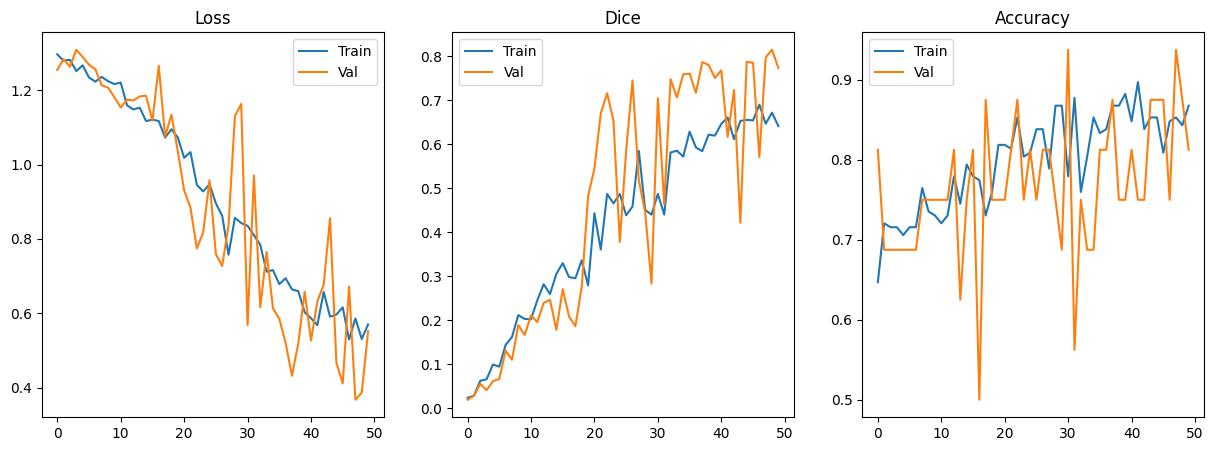

In [6]:
# Plot History
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(history['train_loss'], label='Train')
ax[0].plot(history['val_loss'], label='Val')
ax[0].set_title('Loss')
ax[0].legend()

ax[1].plot(history['train_dice'], label='Train')
ax[1].plot(history['val_dice'], label='Val')
ax[1].set_title('Dice')
ax[1].legend()

ax[2].plot(history['train_acc'], label='Train')
ax[2].plot(history['val_acc'], label='Val')
ax[2].set_title('Accuracy')
ax[2].legend()
plt.show()